## Titanic Xgboost - Kaggle

This workbook is to apply xgboost on titanic dataset, and make a practical sample which can be used in future xgboost model.

The data exploration part is on other workbook called 'Titanic_ML_Lab'

In this workbook, the main things is below:

1. cross validation which is suitable for xgboost
   * whats different? it needs set number of boosting round, early stoping round, and the detail for xgboost package in python is little bit different with scikit package.
   
2. xgboost prameter grid search

3. model training (using xgboost.train instead of xgboost.xgbClassifier)

4. evaluation (same to other workbook: roc, confusion matrix etc...)

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score

### 1. data preparation

In [2]:
# Read the data
train = pd.read_csv('E:\Sebnewrepo\Leo Study\week5/train.csv')
test = pd.read_csv('E:\Sebnewrepo\Leo Study\week5/test.csv')

#### 1.1 Deal with missing value in Age column

In [3]:
test['Survived'] = 2
union_df = train.append(test)
# after append, there will be the duplicate index problem, must reset index here
union_df.reset_index(inplace=True)
union_df.drop(['index','PassengerId'], inplace=True, axis=1)

In [4]:
fill_mean = lambda x: x.fillna(x.mean())
union_df['Age'] = union_df.groupby(['Sex','Pclass'])['Age'].apply(fill_mean)

#### 02.2 Use binary expression to represent Sex

In [5]:
# Transform Sex column to 0(Female) and 1(Male)
# use Mapping function
union_df['Sex'] = union_df['Sex'].map({'male':1, 'female':0})
   
union_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


#### 02.3 Dummy variable coding on Embarked column

In [6]:
# dummy variable on Embarked column

embarked_df = pd.get_dummies(union_df["Embarked"], prefix = 'Embarked')
union_df = pd.concat([union_df, embarked_df], axis = 1)
union_df.drop('Embarked', axis = 1, inplace = True)

In [7]:
test = union_df[union_df['Survived'] == 2]

train = union_df[union_df['Survived'] != 2]
union_df = 0

In [8]:
# Check the missing value
print('missing value on train set')
print(train.isnull().sum())
print("-" * 40)
print('missing value on test set')
print(test.isnull().sum())

missing value on train set
Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin         687
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64
----------------------------------------
missing value on test set
Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin         327
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64


#### 1.4 Shuffle the train set

In [9]:
# shuffle the train set
train = train.sample(frac = 1).reset_index().drop('index', axis = 1)

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,2,"Louch, Mrs. Charles Alexander (Alice Adelaide ...",0,42.000000,1,0,SC/AH 3085,26.0000,NaN,0,0,1
1,0,3,"Hagland, Mr. Ingvald Olai Olsen",1,25.962264,1,0,65303,19.9667,NaN,0,0,1
2,1,2,"Padro y Manent, Mr. Julian",1,30.815380,0,0,SC/PARIS 2146,13.8625,NaN,1,0,0
3,1,2,"Troutt, Miss. Edwina Celia ""Winnie""",0,27.000000,0,0,34218,10.5000,E101,0,0,1
4,1,3,"Bing, Mr. Lee",1,32.000000,0,0,1601,56.4958,NaN,0,0,1


#### 1.5 Ready to train

In [10]:
# Only keep preditors in the train and test table
Pred_cols = ['Pclass','Sex','Age','SibSp','Parch','Embarked_S','Embarked_C','Embarked_Q']
result_cols = ['Survived']

x_train = train[Pred_cols]
x_test = test[Pred_cols]
y_train = train[result_cols]
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked_S,Embarked_C,Embarked_Q
0,2,0,42.000000,1,0,1,0,0
1,3,1,25.962264,1,0,1,0,0
2,2,1,30.815380,0,0,0,1,0
3,2,0,27.000000,0,0,1,0,0
4,3,1,32.000000,0,0,1,0,0


### 2. XgBoost Model

In [11]:
# Kfold and cross validation for xgboost

def kfold_index(x_train, k):
    if k < 1:
        print('K cannot smaller than 1')
        return
    else:
        l = x_train.shape[0] 
        tail = l % k
        q = l // k
        index = [0]
        output_index = []
        # first n_examples % k sub_example have n_examples // k + 1 elements
        for i in range(1,tail):
            index.append((i*q)+1)
        for j in range(tail,k+1):
            index.append(j*q+tail)
        for m in range(len(index)-1):
            output_index.append([index[m],index[m+1]])
        if [0, 0] in output_index:
            output_index.remove([0, 0])      
        #print(output_index)    
        return output_index

# the evaluation method here is accuracy

def cv_xgboost(x_train, y_train, param, num_boosting_round, early_stoping_rounds, kfold):
    
    import xgboost as xgb
    from sklearn import metrics
    # get kfold index
    index = kfold_index(x_train, kfold)
    
    #train each sub-combination
    auc = []
    br = []
    for i in range(kfold):
        print(index)
        cv_xtest = x_train.iloc[index[i][0]:index[i][1],:]
        cv_ytest = y_train.iloc[index[i][0]:index[i][1],]
        # drop the test sub-set 
        cv_xtrain = x_train.drop(x_train.index[index[i][0]:index[i][1]])
        cv_ytrain = y_train.drop(y_train.index[index[i][0]:index[i][1]])
        
        # make the dmatrix for xgboost
        
        d_cvtrain = xgb.DMatrix(data = cv_xtrain, label = cv_ytrain)
        d_cvtest = xgb.DMatrix(data = cv_xtest, label = cv_ytest)
        
        # use xgb.train to train the model
        xg_l = xgb.train(params = param, 
                         dtrain = d_cvtrain, 
                         num_boost_round = num_boosting_round, 
                         early_stopping_rounds = early_stoping_rounds, 
                         evals = [(d_cvtest, 'test_evalset')],
                         verbose_eval = False)
        
        # calculate the auc as the evaluation metric
    
        fpr, tpr, threshold = roc_curve(cv_ytest, xg_l.predict(d_cvtest))
        aa = metrics.auc(fpr, tpr)
        auc.append(aa)  
        
        #get the number of boosting round
        
        bb = xg_l.best_iteration
        br.append(bb)
        #xg_l.best_ntree_limit
        
    return np.mean(auc), np.mean(br)

#### parameter set 0

param_grid = {
    'eta': [0.01, 0.1, 0.2, 0.3],
    'objective':['binary:logistic','reg:logistic'],
    'subsample': [0.75, 1],
    'colsample_bytree': [0.75, 1],
    'max_depth': [15, 20, 30],
    'gamma': [0, 1, 5],
    'num_boosting_round': [50, 100, 200, 500, 1000]
}

In [12]:
##### parameter set 1

param_grid = {
    'eta': [0.1, 0.2, 0.3, 0.4],
    'objective':['binary:logistic', 'reg:logistic'],
    'subsample': [0.75,1],
    'colsample_bytree': [0.75,1],
    'max_depth': [5],
    'gamma': [0, 0.5, 1],
    'num_boosting_round': [1000]
}

##### parameter set 2

param_grid = {
    'eta': [0.1, 0.15, 0.2, 0.3],
    'objective':['reg:logistic'],
    'max_depth': [10, 15,20],
    'gamma': [0, 1, 2],
    'num_boosting_round': [100, 200, 300]
}

In [13]:
s = sorted(param_grid)
combination = it.product(*(param_grid[Name] for Name in s))
print(s)

['colsample_bytree', 'eta', 'gamma', 'max_depth', 'num_boosting_round', 'objective', 'subsample']


In [ ]:
# Grid Search with cross validation

s = sorted(param_grid)
combination = it.product(*(param_grid[Name] for Name in s))

score = 0
for i in list(combination):
    #print(i)
    param = {"objective": i[5], 
             "learning_rate": i[1],
             "max_depth": i[3], 
             "alpha": 10, 
             "gamma": i[2],
             'colsample_bytree': i[0],
             'subsample': i[6],
             'eval_metric': 'auc'
            }
    num_boosting_round = i[4]
    
    scc, num_round = cv_xgboost(x_train, y_train, param, num_boosting_round, early_stoping_rounds = 30, kfold = 10)
    #print(scc)
    if scc >= score:
        #print('true')
        score = scc
        opt = i
        avg_num_round = num_round

print('Best combination of parameters:')
print(s)
print(opt)
print('Average of boosting round for best parameters: %2.0f' % avg_num_round)
print('Best auc scores: %2.3f' % score)

[[0, 90], [90, 179], [179, 268], [268, 357], [357, 446], [446, 535], [535, 624], [624, 713], [713, 802], [802, 891]]


### 3. Evaluation and output

#### 3.1 Train the model

In [83]:
# train the model with parameter set
p = {
    "objective": 'reg:logistic', 
    "learning_rate": 0.3,
    "max_depth": 5, 
    "alpha": 10, 
    "gamma": 0,
    'colsample_bytree': 1,
    'subsample': 0.75
}
Dtrain = xgb.DMatrix(data = x_train, label = y_train)
Dtest= xgb.DMatrix(x_test)

xg_2 = xgb.train(params = p, dtrain = Dtrain, num_boost_round = 60)
y_pred_prb = xg_2.predict(Dtest)

#### 3.2 ROC and AUC

AUC is:
0.8780185131925138


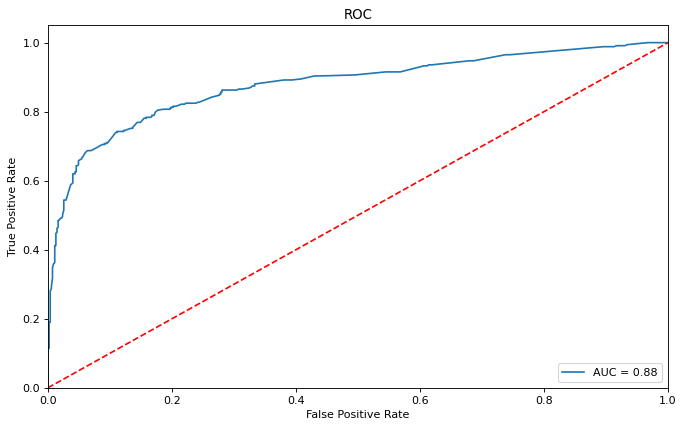

In [84]:

fpr, tpr, threshold = roc_curve(y_train, xg_2.predict(Dtrain))

# Calculate AUC (Area under curve) and ROC figure of the result

auc = metrics.auc(fpr, tpr)
print('AUC is:')
print(auc)
plt.figure(figsize=(10, 6), dpi=80)
plt.title('ROC')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 3.3 Threshold

best_threshold is: 0.51


0.841

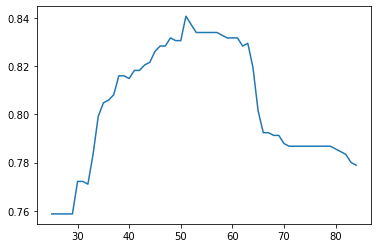

In [85]:
m = []
n = []
for i in range(25,85):
    threshold = i/100

    predicted_proba = xg_2.predict(Dtrain)
    predicted = (predicted_proba [:] >= threshold).astype('int')
    n.append(i)
    m.append(accuracy_score(y_train,predicted))

plt.plot(n,m)

# identify the best threshold
s = np.argsort(m)[::-1]
best_threshold = n[s[0]]
print('best_threshold is: %2.2f' % (best_threshold/100))

threshold = best_threshold/100

predicted_proba = xg_2.predict(Dtrain)
predicted = (predicted_proba [:] >= threshold).astype('int')
accuracy_score(y_train,predicted).round(3)

#### 3.4 Output

In [86]:
threshold = 0.51

predicted_proba = xg_2.predict(Dtest)
predicted = (predicted_proba [:] >= threshold).astype('int')
test = pd.read_csv('E:\Sebnewrepo\Leo Study\week5/test.csv')
test['Survived'] = predicted
output = pd.DataFrame({
    'PassengerID' : test['PassengerId'],
    'Survived' : test['Survived']
})

In [87]:
output.to_csv('E:\Sebnewrepo\Data/xgb_out.csv')